**This block checks if the folder reduced_dir already exists, and if it does, it deletes it.
Then it creates a new empty folder with the same name.**

In [38]:
import shutil
if os.path.exists(reduced_dir):
    shutil.rmtree(reduced_dir)
os.makedirs(reduced_dir, exist_ok=True)


**This block checks if the DATA_DIR folder doesn’t exist, and if it’s missing, it extracts the ZIP file to that location.
After extraction, it shows a message saying the process is done.**

In [39]:

import zipfile
import os
import random
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Paths
zip_path = "/content/drive/MyDrive/loopversedata/EuroSAT_RGB.zip"
extract_path = "/content/EuroSAT_RGB"
DATA_DIR = os.path.join(extract_path, "EuroSAT_RGB")


if not os.path.exists(DATA_DIR):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")

**following code creates a new folder for a smaller dataset by copying only 1000 random images from each class in the original dataset.
It keeps the class folder structure the same and saves the reduced dataset in reduced_dir.**

In [40]:
import os, random, shutil

original_dir = "/content/EuroSAT_RGB/EuroSAT_RGB"
reduced_dir = "/content/EuroSAT_RGB_Reduced"

if os.path.exists(reduced_dir):
    shutil.rmtree(reduced_dir)
os.makedirs(reduced_dir, exist_ok=True)

images_per_class = 1000


for class_name in os.listdir(original_dir):
    src_folder = os.path.join(original_dir, class_name)
    dst_folder = os.path.join(reduced_dir, class_name)
    os.makedirs(dst_folder, exist_ok=True)

    all_images = [f for f in os.listdir(src_folder)
                  if f.lower().endswith(('.jpg','.png','.jpeg'))]
    random.shuffle(all_images)


    selected_images = all_images[:images_per_class]


    for img in selected_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

print("Reduced dataset created at:", reduced_dir)


Reduced dataset created at: /content/EuroSAT_RGB_Reduced


**This block of code\ goes through all images in the dataset and deletes any that are mostly black more than 95% black pixels or unreadable.
There aren't any images which are 95% black, so no images removed**

In [36]:
def clean_images_black_patches(data_dir, black_threshold=0.95):
    removed_count = 0
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                    img = Image.open(img_path).convert("RGB")
                    arr = np.array(img) / 255.0
                    black_pixels = np.sum(np.all(arr < 0.05, axis=-1))
                    total_pixels = arr.shape[0] * arr.shape[1]
                    if black_pixels / total_pixels > black_threshold:
                        os.remove(img_path)
                        removed_count += 1
                except (UnidentifiedImageError, IOError, OSError):
                    os.remove(img_path)
                    removed_count += 1
    print(f"Removed {removed_count} images.")

clean_images_black_patches(reduced_dir)

Removed 0 images.


**This code counts how many images are in each class folder and the total across all folders.
It then prints the total number of images followed by the count for each class.**

In [41]:
def count_images_in_dir(data_dir):
    import os
    total = 0
    per_class = {}
    for cls in sorted(os.listdir(data_dir)):
        p = os.path.join(data_dir, cls)
        if os.path.isdir(p):
            cnt = len([f for f in os.listdir(p) if f.lower().endswith(('.jpg','.png','.jpeg'))])
            per_class[cls] = cnt
            total += cnt
    return total, per_class

total, per_class = count_images_in_dir(reduced_dir)
print("Total:", total)
for k,v in per_class.items():
    print(k, v)


Total: 10000
AnnualCrop 1000
Forest 1000
HerbaceousVegetation 1000
Highway 1000
Industrial 1000
Pasture 1000
PermanentCrop 1000
Residential 1000
River 1000
SeaLake 1000


**Following block loads images from reduced dataset folder and splits them into training and validation sets.
I applied a Gaussian blur filter to each image, rescales pixel values to 0–1, and prepare the data for efficient training with caching, shuffling, and prefetching.**

In [42]:
import tensorflow as tf
import numpy as np

img_height, img_width = 150, 150
batch_size = 32

# Gaussian kernel (constant)

kernel_vals = np.array([[1, 2, 1],
                        [2, 4, 2],
                        [1, 2, 1]], dtype=np.float32)
kernel_vals /= np.sum(kernel_vals)
kernel_vals = kernel_vals[:, :, np.newaxis, np.newaxis]
kernel_vals = np.repeat(kernel_vals, 3, axis=2)

GAUSSIAN_KERNEL = tf.constant(kernel_vals, dtype=tf.float32)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    reduced_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    reduced_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds_raw.class_names
print("Class names:", class_names)

# Gaussian blur
def gaussian_blur(image, label):
    blurred = tf.nn.depthwise_conv2d(
        image,
        GAUSSIAN_KERNEL,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )
    return blurred, label

rescale_layer = tf.keras.layers.Rescaling(1./255)

train_ds = (
    train_ds_raw
    .map(gaussian_blur, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds_raw
    .map(gaussian_blur, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


**Checking if scaling is done correctly**

In [44]:
for images, labels in train_ds.take(1):
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())

Min pixel value: 0.045412794
Max pixel value: 1.0


**In following code I build a CNN model with three convolutional layers followed by max pooling, then flattens the data, and finally uses two dense layers one hidden layer with 512 neurons and an output layer with 10 neurons for class predictions.
The input images are expected to be 150x150 pixels with 3 color channels.**

In [45]:

model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The fourth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 10 neurons for 10 classes
    tf.keras.layers.Dense(10, activation='softmax')
])

**Following block of code sets up the model for training I choose Adam optimizer, and sparse categorical cross entropy as the loss function good for multi class classification with integer labels**

In [46]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.2997 - loss: 1.8404 - val_accuracy: 0.5195 - val_loss: 1.2509
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 225s 876ms/step - accuracy: 0.5886 - loss: 1.1030 - val_accuracy: 0.6055 - val_loss: 1.0329
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.6752 - loss: 0.8771 - val_accuracy: 0.6910 - val_loss: 0.8303
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7627 - loss: 0.6716 - val_accuracy: 0.7515 - val_loss: 0.7148
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 949ms/step - accuracy: 0.8021 - loss: 0.5524 - val_accuracy: 0.7855 - val_loss: 0.6445
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 266s 966ms/step - accuracy: 0.8474 - loss: 0.4394 - val_accuracy: 0.7725 - val_loss: 0.6698
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 228s 914ms/step - accuracy: 0.8840 - loss: 0.3426 - val_accuracy: 0.7705 - val_loss: 0.6923
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 895ms/step - accuracy: 0.9066 - loss: 0.

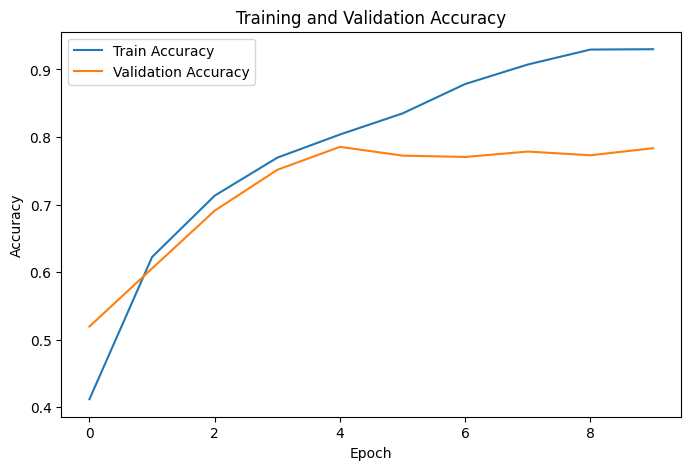

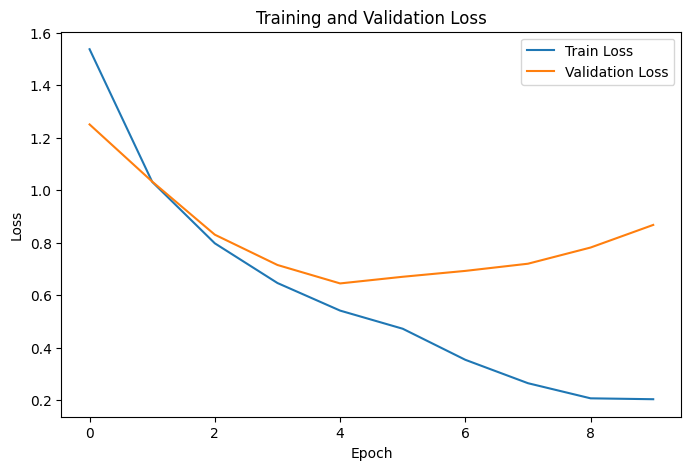

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Added two more convolutional and maxpooling layers**

In [54]:

model2 = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 10 neurons for 10 classes
    tf.keras.layers.Dense(10, activation='softmax')
])

**I changed optimizer from adam to RMSprop**

In [55]:
model2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**model2 with 5 CNN layers and RMSprop optimizer achieved strong performance, reaching up to around 80% validation accuracy, slightly better than Adam in some epochs. However, early epochs showed similar accuracy 77% for both optimizers, indicating comparable initial learning. Overall, RMSprop helped improve validation accuracy slightly but results were fairly close between the two.**

In [56]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 191s 755ms/step - accuracy: 0.2094 - loss: 2.0203 - val_accuracy: 0.3315 - val_loss: 1.7183
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 792ms/step - accuracy: 0.4083 - loss: 1.5434 - val_accuracy: 0.4695 - val_loss: 1.2930
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 738ms/step - accuracy: 0.5211 - loss: 1.2869 - val_accuracy: 0.6085 - val_loss: 1.0503
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 748ms/step - accuracy: 0.6107 - loss: 1.0892 - val_accuracy: 0.6680 - val_loss: 0.9227
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 203s 752ms/step - accuracy: 0.6541 - loss: 0.9852 - val_accuracy: 0.6655 - val_loss: 0.9215
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 191s 764ms/step - accuracy: 0.6919 - loss: 0.8630 - val_accuracy: 0.6840 - val_loss: 0.8490
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 189s 757ms/step - accuracy: 0.7314 - loss: 0.7717 - val_accuracy: 0.6700 - val_loss: 0.9049
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 204s 764ms/step - accuracy: 0.7447 -

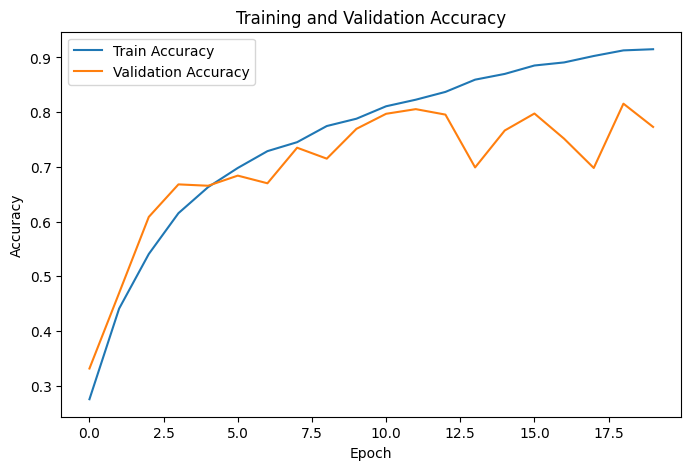

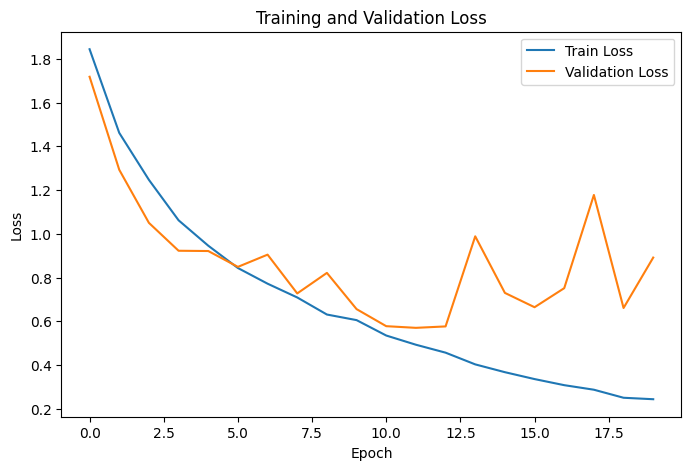

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(8,5))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**following code is to make prediction on sample data and save it in csv**

In [59]:
import os
import numpy as np
import pandas as pd

dataset_dir = "/content/EuroSAT_RGB_Reduced"
img_height, img_width = 150, 150
class_names = sorted(os.listdir(dataset_dir))

val_image_paths = []
val_labels = []

for label_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_dir, class_name)
    all_images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    all_images.sort()
    val_count = int(len(all_images) * 0.2)
    val_images = all_images[-val_count:]

    for img_name in val_images:
        val_image_paths.append(os.path.join(class_folder, img_name))
        val_labels.append(label_idx)


def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])

    kernel_vals = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]], dtype=np.float32)
    kernel_vals /= np.sum(kernel_vals)
    kernel_vals = kernel_vals[:, :, np.newaxis, np.newaxis]
    kernel_vals = np.repeat(kernel_vals, 3, axis=2)
    GAUSSIAN_KERNEL = tf.constant(kernel_vals, dtype=tf.float32)

    img = tf.expand_dims(img, 0)
    img = tf.nn.depthwise_conv2d(img, GAUSSIAN_KERNEL, strides=[1,1,1,1], padding='SAME')
    img = tf.squeeze(img, axis=0)

    img = img / 255.0
    return img

predictions = []

for img_path in val_image_paths:
    img = load_and_preprocess_image(img_path)
    img = tf.expand_dims(img, 0)
    pred = model.predict(img, verbose=0)
    pred_label = np.argmax(pred, axis=1)[0]
    predictions.append(pred_label)

df = pd.DataFrame({
    "image_name": [os.path.basename(p) for p in val_image_paths],
    "true_label": val_labels,
    "predicted_label": predictions
})

df.to_csv("validation_predictions.csv", index=False)
print("CSV saved as validation_predictions.csv")


CSV saved as validation_predictions.csv


In [60]:
!ls -l validation_predictions.csv

-rw-r--r-- 1 root root 45020 Aug  9 14:34 validation_predictions.csv


In [61]:
from google.colab import files
files.download('validation_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>